**QR разложение методом Хаусхолдера**

 
Не вышло сделать swig :(

***PURE PYTHON***

In [2]:
import math as m
import random as rng
import cmath
import os, sys
import random as rng
from typing import *
import time
import numpy as np
from numpy.linalg import norm
from numba import jit
import matplotlib as plot

%matplotlib inline

os.environ['OMP_NUM_THREADS'] = '1'

G_COLS = 4
G_ROWS = 4
BS = int(G_ROWS / 2)

def atu(A: List, v: List, mult):
    w = [0 for j in range(0, G_ROWS)]
    for i in range(0, G_COLS):
        w[i] = 2 * sum([A[i + j * G_COLS] * v[j] / mult for j in range(0, G_ROWS)])

    return w

def uwt(v, w):
    out = [v[i] * w[j] for i in range(0, G_ROWS) for j in range(0, G_ROWS)]
    return out

def sq(x):
    return x * x

def householder_simple(A):
    Q = [0 for i in range (0, G_ROWS) for j in range(0, G_ROWS)]
    w = None
    for i in range(0, G_COLS - 1):
        v = [A[i + j * G_COLS] for j in range(0, G_ROWS)]
        for j in range(0, i):
            v[j] = 0
        fnorm_v2 = sum(map(sq, v))
        v[i] += (v[i] / abs(v[i])) * m.sqrt(fnorm_v2)
        fnorm_v2 = sum(map(sq, v)) 
        for j in range(i, G_ROWS):
            Q[i + j * G_COLS] = v[j]
        w = atu(A, v, fnorm_v2)
        refl = uwt(v, w)
        # w = A^T v / fnorm(w)
        for i in range(0, G_ROWS * G_COLS):
            A[i] -= refl[i]
    return Q, A
            
        
        

def main_simple():

    rng.seed()

    # create matrix
    A = [rng.uniform(100, 1000) for i in range(0,  G_COLS * G_ROWS)]
    householder_simple(A)
    print(len(A))

In [5]:
%%time
main_simple()


262144
Wall time: 2min 14s


***PYTHON + NUMPY***

In [3]:

def householder_numpy(A):
    # set x vector
    res = np.copy(A)
    Q = np.zeros((G_COLS, G_ROWS))
    w = None
    for i in range(0, G_COLS - 1):
        v = np.copy(res[:, i])
        v[:i] = 0
        fnorm_v2 = np.sqrt(v @ v) # np sqrt faster than linalg norm in particular case
        v[i] += np.sign(v[i]) * fnorm_v2
        fnorm_v2 = v @ v
        Q[:, i] = v
        w = 2 * np.dot(res.T,np.divide(v, fnorm_v2))
        refl = np.outer(v, w)
        # w = A^T v / fnorm(w)
        res -= refl
    return Q, res
        

def main_numpy():

    # create matrix
    A = np.random.rand(G_ROWS, G_COLS)
    A[0, 0] = 2
    A[0, 1] = 3
    A[1, 0] = 3
    A[1, 1] = 2
    res = np.copy(A)
    start = time.time()
    Q, R = householder_numpy(res)
    print(Q)
    print(R)
    print(time.time() - start)
    print(Check2d(A, Q, R))
    

In [115]:
%%time
main_numpy()

[[5.60555128 0.        ]
 [3.         0.        ]]
[[-3.60555128e+00 -3.32820118e+00]
 [ 8.88178420e-16 -1.38675049e+00]]
0.0009970664978027344
1.5770980562824344e-16
1.1749496091904413e-15
Wall time: 997 µs


***Здесь сравнивал что лучше***

In [5]:
v = np.random.rand(1000)

In [6]:
%%time
for i in range(1,1000000):
    np.sqrt(v @ v)

Wall time: 6.12 s


In [7]:
%%time
for i in range(1,1000000):
    norm(v)

Wall time: 11.3 s


***STATIC_BLOCK + NUMPY***

In [4]:
def householder_numpy_bl(A):
    Q = np.zeros((G_COLS, G_ROWS))
     # seting blocks:
    b00 = np.copy(A[0:int(BS), 0:int(BS)])
    b01 = np.copy(A[0:int(BS), int(BS):G_COLS])
    b10 = np.copy(A[int(BS):G_ROWS, 0:int(BS)])
    b11 = np.copy(A[int(BS):G_ROWS, int(BS):G_COLS])
    for i in range(0, int(G_COLS / 2)):
        v00 = np.copy(b00[:, i])
        v10 = np.copy(b10[:, i])
        v00[:i] = 0
        fnorm_v2 = np.sqrt(v00 @ v00 + v10 @ v10) # np sqrt faster than linalg norm in particular case
        v00[i] += np.sign(v00[i]) * fnorm_v2
        fnorm_v2 = v00 @ v00 + v10 @ v10
        Q[:BS,i] = v00 
        Q[BS:G_COLS,i] = v10 
        #A.T multiply by v
        w00 = np.divide(2 * (b00.T @ v00 + b10.T @ v10), fnorm_v2)
        w10 = np.divide(2 * (b01.T @ v00 + b11.T @ v10), fnorm_v2) 
        refl00 = np.outer(v00, w00)
        refl01 = np.outer(v00, w10) 
        refl10 = np.outer(v10, w00)
        refl11 = np.outer(v10, w10)
        b00 -= refl00
        b01 -= refl01
        b10 -= refl10
        b11 -= refl11
        
    for i in range(0, int(BS) - 1):
        v11 = np.copy(b11[:, i])
        v11[:i] = 0
        fnorm_v2 = np.sqrt(v11 @ v11) # np sqrt faster than linalg norm in particular case
        v11[i] += np.sign(v11[i]) * fnorm_v2
        fnorm_v2 = v11 @ v11
        Q[BS:G_ROWS,i + BS] = v11
        #A.T multiply by v
        w11 = np.divide(2 * (b11.T @ v11), fnorm_v2)
        refl11 = np.outer(v11, w11)
        b11 -= refl11
        
    A[0:int(BS), 0:int(BS)] = b00
    A[0:int(BS), int(BS):G_COLS] = b01
    A[int(BS):G_ROWS, 0:int(BS)] = b10
    A[int(BS):G_ROWS, int(BS):G_COLS] = b11
    return Q, A

def main_numpy_bl():

    # create matrix
    A = np.random.rand(G_ROWS, G_COLS)
    A[0, 0] = 2
    A[0, 1] = 3
    A[1, 0] = 3
    A[1, 1] = 2
    res = np.copy(A)
    start = time.time()
    Q, R = householder_numpy_bl(res)
    print(Q)
    print(R)
    print(time.time() - start)
    print(Check2d(A, Q, R))
    

In [143]:
%%time
main_numpy_bl()

[[ 5.80644791  0.          0.          0.        ]
 [ 3.         -2.8139893   0.          0.        ]
 [ 0.83730455  0.03285265 -0.60989054  0.        ]
 [ 0.88767493 -0.04674563  0.52199481  0.        ]]
[[-3.80644791e+00 -3.59305633e+00 -1.18870444e+00 -7.80731404e-01]
 [-4.44819013e-16  1.40757469e+00  2.11130921e-01  7.26326452e-01]
 [ 1.21400092e-16 -6.93889390e-18  5.28328452e-01 -8.75717676e-02]
 [ 9.62558734e-17  6.93889390e-18  0.00000000e+00  2.53344795e-01]]
0.0010111331939697266
4.322212449724815e-16
2.2023310314175786e-15
Wall time: 2 ms


Проверим кубичность роста замедления:

In [231]:
G_COLS = 2048
G_ROWS = 2048
start = time.time()
main_numpy_bl()
print(f'2048: {time.time() - start} ')


G_COLS = 1024
G_ROWS = 1024
start = time.time()
for i in range(0, 8):
    main_numpy_bl()
print(f'1024: {time.time() - start}')
    

40.20645809173584
2048: 40.26330828666687 
5.189120531082153
5.3557045459747314
5.126286506652832
5.04351019859314
5.297830820083618
5.087391376495361
5.101398229598999
5.297780752182007
1024: 41.60073208808899


In [36]:
hh_np_nb = []

Рост примерно кубический))

***NUMPY + NUMBA***

In [45]:
G_COLS = 2048
G_ROWS = G_COLS
BS = int(G_COLS / 2)
@jit(nopython=True)
def householder_numpy_bl_nb(A):
    
     # setting blocks:
    Q = np.zeros((G_COLS, G_ROWS))
    b00 = np.copy(A[0:int(G_ROWS / 2), 0:int(G_COLS / 2)])
    b01 = np.copy(A[0:int(G_ROWS / 2), int(G_COLS / 2):G_COLS])
    b10 = np.copy(A[int(G_ROWS / 2):G_ROWS, 0:int(G_COLS / 2)])
    b11 = np.copy(A[int(G_ROWS / 2):G_ROWS, int(G_COLS / 2):G_COLS])
    for i in range(0, int(G_COLS / 2)):
        v00 = np.copy(b00[:, i])
        v10 = np.copy(b10[:, i])
        v00[:i] = 0
        fnorm_v2 = np.sqrt(v00 @ v00 + v10 @ v10) # np sqrt faster than linalg norm in particular case
        v00[i] += np.sign(v00[i]) * fnorm_v2
        Q[:BS, i] = v00
        Q[BS:G_ROWS, i] = v10
        fnorm_v2 = v00 @ v00 + v10 @ v10
        #A.T multiply by v
        w00 = np.divide(2 * (b00.T @ v00 + b10.T @ v10), fnorm_v2)
        w10 = np.divide(2 * (b01.T @ v00 + b11.T @ v10), fnorm_v2) 
        refl00 = np.outer(v00, w00)
        refl01 = np.outer(v00, w10) 
        refl10 = np.outer(v10, w00)
        refl11 = np.outer(v10, w10)
        b00 -= refl00
        b01 -= refl01
        b10 -= refl10
        b11 -= refl11
        
    for i in range(0, int(G_COLS / 2) - 1):
        v11 = np.copy(b11[:, i])
        v11[:i] = 0
        fnorm_v2 = np.sqrt(v11 @ v11) # np sqrt faster than linalg norm in particular case
        v11[i] += np.sign(v11[i]) * fnorm_v2
        Q[BS:G_ROWS, i + BS] = v11
        fnorm_v2 = v11 @ v11
        #A.T multiply by v
        w11 = np.divide(2 * (b11.T @ v11), fnorm_v2)
        refl11 = np.outer(v11, w11)
        b11 -= refl11
        
    A[0:int(BS), 0:int(BS)] = b00
    A[0:int(BS), int(BS):G_COLS] = b01
    A[int(BS):G_ROWS, 0:int(BS)] = b10
    A[int(BS):G_ROWS, int(BS):G_COLS] = b11
    return A, Q

def main_numpy_bl_numba():

    # create matrix
    A = np.random.rand(G_ROWS, G_COLS)
    res = np.copy(A)
    start = time.perf_counter()
    R, Q = householder_numpy_bl_nb(res)
    hh_np_nb.append(time.perf_counter() - start)
    
    # print(Check2d(A, Q, R))
    

In [46]:
%%time
main_numpy_bl_numba()

Wall time: 35.8 s


In [47]:
print(hh_np_nb)

[3.5192934000001515, 3.1560814999998, 4.194681599999967, 7.188339799999994, 35.555440499999804]


In [21]:
hh_py_nb = []

**PURE PYTHON + NUMBA (with ndarrays)**

In [29]:
G_COLS = 2048
G_ROWS = G_COLS
BS = int(G_COLS / 2)
@jit(nopython=True)
def householder_simple_nb(A):
    # set x vector
    q = np.zeros((G_COLS, G_ROWS))
    b00 = np.zeros(BS * BS)
    for i in range(0, BS):
        for j in range(0, BS):
            b00[j + i * BS] = A[j + i * G_COLS]

    b01 = np.zeros(BS * BS)
    for i in range(0, BS):
        for j in range(0, BS):
            b01[j + i * BS] = A[(j + BS) + i * G_COLS]
    b10 = np.zeros(BS * BS)
    for i in range(0, BS):
        for j in range(0, BS):
            b10[j + i * BS] = A[j + (i + BS) * G_COLS]
    b11 = np.zeros(BS * BS)
    for i in range(0, BS):
        for j in range(0, BS):
            b11[j + i * BS] = A[(j + BS) + (i + BS) * G_COLS]
    
    for i in range(0, BS):
        v00 = np.zeros(BS)
        v10 = np.zeros(BS)
        for j in range(0, BS):
            v00[j] = b00[i + j * BS]
            v10[j] = b10[i + j * BS]
        for j in range(0, i):
            v00[j] = 0
        # norm
        x1 = 0
        for j in range(0, BS):
            x1 += v00[j] * v00[j] + v10[j] * v10[j]
        x1 = m.sqrt(x1)
        v00[i] += (v00[i] / abs(v00[i])) * x1
            
        x1 = 0
        for j in range(0, BS):
            x1 += v00[j] * v00[j] + v10[j] * v10[j]
        for j in range(0, BS):
            q[j, i] = v00[j]
            q[j + BS, i] = v10[j]
        w00 = np.zeros(BS)
        w10 = np.zeros(BS)
        for k in range(0, BS):
            sm1 = 0
            sm2 = 0
            for j in range(0, BS):
                sm1 += 2 * (b00[k + j * BS] * v00[j] + b10[k + j * BS] * v10[j]) / x1
                sm2 += 2 * (b01[k + j * BS] * v00[j] + b11[k + j * BS] * v10[j]) / x1
            w00[k] = sm1
            w10[k] = sm2
        
        for j in range(0, BS):
            for k in range(0, BS):
                b00[k + j * BS] -= v00[j] * w00[k]
                b01[k + j * BS] -= v00[j] * w10[k]
                b10[k + j * BS] -= v10[j] * w00[k]
                b11[k + j * BS] -= v10[j] * w10[k]
        
    for i in range(0, BS - 1):
        v00 = np.zeros(BS)
        for j in range(0, BS):
            v00[j] = b11[i + j * BS]
        for j in range(0, i):
            v00[j] = 0
        # norm
        x1 = 0
        for j in range(0, BS):
            x1 += v00[j] * v00[j]
        x1 = m.sqrt(x1)
        v00[i] += (v00[i] / abs(v00[i])) * x1
        x1 = 0
        for j in range(0, BS):
            x1 += v00[j] * v00[j]
        for j in range(0, BS):
            q[j + BS, i + BS] = v00[j]
        w00 = np.zeros(BS)
        for k in range(0, BS):
            sm1 = 0
            for j in range(0, BS):
                sm1 += 2 * (b11[j + k * BS] * v00[j]) / x1
            w00[k] = sm1
        
        for j in range(0, BS):
            for k in range(0, BS):
                b11[k + j * BS] -= v00[j] * w00[k]
    
    for i in range(0, BS):
        for j in range(0, BS):
            A[j + i * G_COLS] = b00[j + i * BS]
            A[j + BS + i * G_COLS] = b01[j + i * BS]
            A[j + (i + BS) * G_COLS] = b10[j + i * BS]
            A[j + BS + (i + BS) * G_COLS] = b11[j + i * BS]
            
    return A, q

def main_simple_nb():

    rng.seed()

    # create matrix
    A = np.random.rand(G_COLS * G_ROWS)
    res = np.copy(A)
    start = time.perf_counter()
    R, Q = householder_simple_nb(res)
    hh_py_nb.append(time.perf_counter() - start)
    R.shape = G_COLS, G_ROWS
    Q.shape = G_COLS, G_ROWS
    A.shape = G_COLS, G_ROWS
    #print(Check2d(A, Q, R))

In [30]:
%%time
main_simple_nb()

Wall time: 1min 7s


In [31]:
print(hh_py_nb)

[0.008214100000031976, 4.57883240000001, 2.5963136000000304, 8.382828000000018, 67.43721690000007]


Теперь, когда все проверили, можно приступать к построению графиков

128
256
512
1024
2048


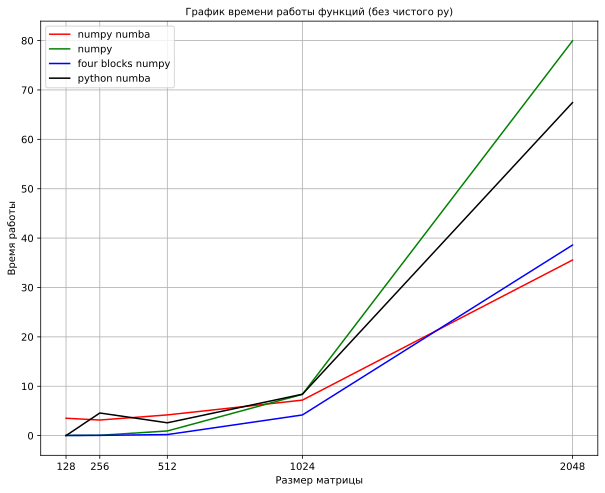

In [49]:
#названия методов
#householder_simple householder_simple_nb, householder_numpy, householder_numpy_bl, householder_numpy_bl_nb
res_hh_py_nb = [] 
res_hh_np = [] 
res_hh_np_bl = [] 
res_hh_np_bl_nb = [] 
x_val = [128, 256, 512, 1024, 2048]
for i in x_val:
    print(i)
    G_COLS = i
    G_ROWS = i
    BS = int(G_COLS / 2)
    A = np.random.rand(G_COLS,  G_ROWS)
    
    
    
    res = np.copy(A)
    start = time.perf_counter()
    householder_numpy(res)
    res_hh_np.append(time.perf_counter() - start)
    
    res = np.copy(A)
    start = time.perf_counter()
    householder_numpy_bl(res)
    res_hh_np_bl.append(time.perf_counter() - start)
    
    # нанесем результаты на график
    
import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig = plt.figure(figsize=(10,8))

plt.title('График времени работы функций (без чистого py)', fontsize=10)

# рисуем графики
plt.plot(x_val, hh_np_nb, linestyle='-', color='r', label = 'numpy numba')
plt.plot(x_val, res_hh_np, linestyle='-', color='g', label = 'numpy')
plt.plot(x_val, res_hh_np_bl, linestyle='-', color='b', label = 'four blocks numpy')
plt.plot(x_val, hh_py_nb, linestyle='-', color='black', label = 'python numba')

# linestyle: '--' - dashed line style, '-.'- dash-dot line style, ...
# color: r, g, b, ...
# marker: '.', 'o', '+', ...

# сетка графика
plt.grid(True) 

# разметка осей
plt.xticks(x_val, x_val)
# plt.yticks([x*0.05 for x in range(0, 1)], [x*0.05 for x in range(0, 1)])

# подписи осей
plt.ylabel('Время работы',  fontsize=10)
plt.xlabel('Размер матрицы',  fontsize=10)

plt.legend()
plt.show()

Видим что блочность сильно влияет на перфоманс на таблицах большего размера. Также видим что нумба эффективнее ускоряет на бОльших размерах чем голый Numpy

Видим что методы с нумбой что то быстро работают

In [12]:
def Check2d(A, Q, R):
    Q_fin = np.identity(G_ROWS)
    E = np.identity(G_ROWS)
    for i in range(0, G_COLS - 1):
        v = Q[:, i]
        Q_fin = Q_fin @ (E - 2 * np.outer(v,v) / (v @ v))
        
        
    print(np.linalg.norm(E - Q_fin.T @ Q_fin))
    out = np.linalg.norm(A - Q_fin @ R)
    return out

In [62]:
t = np.zeros(123)
print(t)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [46]:
print(np.outer(t[:, 0], t[0]))

[[1. 2.]
 [3. 6.]]


In [10]:
v = np.ones(5)
v[:0] = 0
print(v)

[1. 1. 1. 1. 1.]
